# UT3 – Procesamiento de Datos Masivos y Gestión de la Información
## Actividad práctica: Mini-pipeline de Big Data con Kafka (RA3 – Sistemas de Big Data)
En este notebook vamos a construir un **mini-pipeline de datos** que combine:
1. Ingesta batch (CSV/JSON → DataFrame)
2. Ingesta en streaming usando Apache Kafka (productor + consumidor)
3. Limpieza y preprocesamiento
4. Modelado de datos (conceptual y lógico)
5. Evaluación de calidad e integridad
6. Consultas para extracción de valor
**Resultado de Aprendizaje trabajado (RA3 – SPS):**
> Gestiona y almacena datos facilitando la búsqueda de respuestas en grandes conjuntos de datos.

Autor/a: Grupo 6

Fecha: **14/01/2026**

In [ ]:
# @title Carga de librerías principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import kagglehub
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")
print("Librerías de análisis de datos cargadas correctamente.")

Librerías de análisis de datos cargadas correctamente.


In [ ]:

!pip install kafka-python
from kafka import KafkaProducer, KafkaConsumer
import json
import time

# ==============================================
# CONFIGURACIÓN DEL CLUSTER KAFKA (REMOTO)
# ==============================================
# IMPORTANTE: Configura las credenciales de acceso al servidor remoto

# 1) Servidores bootstrap del cluster Kafka (remoto)
# Prueba primero con 9092, si no funciona prueba con 443
KAFKA_BOOTSTRAP_SERVERS = ["varios-kafka-w7jdao-0b4f0a-78-46-205-44.traefik.me:9092"]
# Alternativa si 9092 no funciona:
# KAFKA_BOOTSTRAP_SERVERS = ["varios-kafka-w7jdao-0b4f0a-78-46-205-44.traefik.me:443"]

# 2) Nombre del topic a utilizar para la práctica
KAFKA_TOPIC = "bigdata_ut3"  # o "ut3_g1", "ut3_g2", etc. según tu grupo

# 3) ¿El cluster usa seguridad SASL?
USE_SASL_SSL = False  # Sin autenticación, solo PLAINTEXT

# 4) Configuración de seguridad (sin autenticación para este servidor)
KAFKA_SECURITY_CONFIG = {
    "security_protocol": "PLAINTEXT",  # Sin SSL y sin autenticación SASL
    # Timeouts aumentados para conexiones remotas
    "request_timeout_ms": 60000,  # 60 segundos
    "metadata_max_age_ms": 300000,  # 5 minutos
}

print("✅ Cliente Kafka preparado para conexión REMOTA.")
print(f"Bootstrap Server: {KAFKA_BOOTSTRAP_SERVERS[0]}")
print(f"Topic: {KAFKA_TOPIC}")
print(f"Security Protocol: {KAFKA_SECURITY_CONFIG['security_protocol']} (sin SSL, sin autenticación)")
print(f"Autenticación SASL: {'Activada' if USE_SASL_SSL else 'Desactivada'}")
print("\n✅ Configuración lista. No se requieren credenciales.")

✅ Cliente Kafka preparado para conexión REMOTA.
Bootstrap Server: varios-kafka-w7jdao-0b4f0a-78-46-205-44.traefik.me:9092
Topic: bigdata_ut3
Security Protocol: PLAINTEXT (sin SSL, sin autenticación)
Autenticación SASL: Desactivada

✅ Configuración lista. No se requieren credenciales.


## 1. Descripción del dataset y metadatos

**Origen del dataset**: Kaggle

**Tipo de dato**: Estructurado (datos organizados en filas y columnas con atributos definidos)

**Metadatos básicos**:
- **Nombre del dataset**: Boeing Supplier List
- **Origen / URL**: https://www.kaggle.com/datasets/donnetew/boeing-supplier-list
- **Número aproximado de registros**: Variable (depende del dataset)
- **Número de columnas**: Variable (depende del dataset)
- **Temática**: Lista de proveedores de Boeing con información sobre empresas suministradoras
- **Formato**: CSV

**Descripción adicional**: Este dataset contiene información estructurada sobre los proveedores de Boeing, incluyendo datos sobre empresas que suministran productos o servicios a Boeing. El dataset puede incluir información como nombres de empresas, ubicaciones, tipos de productos/servicios, y otros datos relevantes sobre la cadena de suministro.

In [ ]:
# @title 🧾 Metadatos del dataset (rellenar)
metadatos = {
    "nombre_dataset": "Boeing Supplier List",
    "origen": "Kaggle",
    "url_fuente": "https://www.kaggle.com/datasets/donnetew/boeing-supplier-list",
    "tipo_dato": "estructurado",
    "formato": "CSV",
    "descripcion": "Dataset con información sobre proveedores de Boeing, incluyendo datos sobre empresas que suministran productos o servicios. El dataset contiene información sobre la cadena de suministro de Boeing, incluyendo nombres de empresas, ubicaciones, tipos de productos/servicios y otros datos relevantes."
}
metadatos

{'nombre_dataset': 'Boeing Supplier List',
 'origen': 'Kaggle',
 'url_fuente': 'https://www.kaggle.com/datasets/donnetew/boeing-supplier-list',
 'tipo_dato': 'estructurado',
 'formato': 'CSV',
 'descripcion': 'Dataset con información sobre proveedores de Boeing, incluyendo datos sobre empresas que suministran productos o servicios. El dataset contiene información sobre la cadena de suministro de Boeing, incluyendo nombres de empresas, ubicaciones, tipos de productos/servicios y otros datos relevantes.'}

In [ ]:
# @title Carga de datos (ingesta batch)
# Descargar el dataset - kagglehub devuelve la ruta donde se descargó
path = kagglehub.dataset_download("donnetew/boeing-supplier-list")

# Listar archivos en el directorio para ver qué archivo CSV contiene
import os
archivos = os.listdir(path)
print(f"Archivos en el directorio: {archivos}")

# Buscar el archivo CSV (puede tener diferentes nombres)
csv_files = [f for f in archivos if f.endswith('.csv')]
if csv_files:
    nombre_archivo = csv_files[0]  # Tomar el primer CSV encontrado
    print(f"\n📄 Cargando archivo: {nombre_archivo}")
    df = pd.read_csv(f"{path}/{nombre_archivo}")
else:
    # Si no se encuentra CSV, intentar con nombre común
    print("\n⚠️ No se encontró CSV, intentando con nombre común...")
    try:
        df = pd.read_csv(f"{path}/boeing-supplier-list.csv")
    except:
        # Último intento con cualquier archivo en el directorio
        df = pd.read_csv(f"{path}/{archivos[0]}")

# Opción B: Cargar desde archivo subido a Colab (descomentar si se usa)
# from google.colab import files
# uploaded = files.upload()
# df = pd.read_csv("NOMBRE_ARCHIVO.csv") # TODO

print("\nDimensiones del dataset (filas, columnas):", df.shape)
print("\nPrimeras filas del dataset:")
df.head()

Using Colab cache for faster access to the 'boeing-supplier-list' dataset.
Archivos en el directorio: ['BoeingSupplierListv2.csv', 'Boeing Supplier List.csv']

📄 Cargando archivo: BoeingSupplierListv2.csv

Dimensiones del dataset (filas, columnas): (397, 3)

Primeras filas del dataset:


,Supplier,Country,Category
0,3M,USA,Chemicals
1,"3V Fasteners Company, Inc.",USA,Fasteners
2,"A&B Aerospace, Inc.",USA,Components
3,"Aadox Manufacturing Co, Inc.",USA,Fasteners
4,Accurate Bushing Company,USA,Bearings


In [ ]:
# @title 🔍 Exploración inicial del dataset
print("Información general del dataset:")
df.info()
print("\nDescripción estadística de variables numéricas:")
display(df.describe())
print("\nPrimeras filas:")
display(df.head())
print("\nNúmero de valores nulos por columna:")
display(df.isnull().sum())

Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Supplier  397 non-null    object
 1   Country   397 non-null    object
 2   Category  397 non-null    object
dtypes: object(3)
memory usage: 9.4+ KB

Descripción estadística de variables numéricas:


,Supplier,Country,Category
count,397,397,397
unique,393,16,73
top,Parker Aerospace,USA,Components
freq,2,324,77



Primeras filas:


,Supplier,Country,Category
0,3M,USA,Chemicals
1,"3V Fasteners Company, Inc.",USA,Fasteners
2,"A&B Aerospace, Inc.",USA,Components
3,"Aadox Manufacturing Co, Inc.",USA,Fasteners
4,Accurate Bushing Company,USA,Bearings



Número de valores nulos por columna:


,0
Supplier,0
Country,0
Category,0


## 2. Objetivos de negocio y preguntas clave
Define **al menos 3 preguntas de negocio** que quieras responder con este dataset.
Ejemplos:
- ¿Qué factores influyen más en X?
- ¿Qué tipo de clientes generan más ingresos?
- ¿Qué días/horas se concentra más actividad?
> Escribe aquí tus preguntas:
1. ¿Qué países concentran la mayor cantidad de proveedores en la cadena de suministro de Boeing? (Análisis de distribución geográfica y concentración de riesgo)
2. ¿Cuáles son las categorías de productos/servicios más comunes y cómo se distribuyen geográficamente? (Análisis de diversificación por categoría y país)
3. ¿Existe una dependencia geográfica excesiva en alguna categoría específica de proveedores? (Evaluación de riesgo de concentración geográfica por tipo de componente)

In [ ]:
# @title 🔍 Test de conexión a Kafka (opcional - ejecutar antes del productor)
# Esta celda verifica que la conexión a Kafka funciona correctamente

print("🔍 Probando conexión a Kafka...")
print(f"Servidor: {KAFKA_BOOTSTRAP_SERVERS[0]}")
print(f"Topic: {KAFKA_TOPIC}")
print(f"Security Protocol: {KAFKA_SECURITY_CONFIG.get('security_protocol', 'N/A')}")
print(f"Autenticación: {'SASL activada' if USE_SASL_SSL else 'Sin autenticación (PLAINTEXT)'}")

try:
    # Intentar crear un productor de prueba con timeouts aumentados
    test_producer_config = {
        "bootstrap_servers": KAFKA_BOOTSTRAP_SERVERS,
        "value_serializer": lambda v: json.dumps(v).encode("utf-8"),
        "api_version": (2, 0, 0),  # Versión mínima compatible (evita usar versión 0 antigua)
        "request_timeout_ms": 60000,       # 60 segundos (reducido para fallar más rápido)
        "metadata_max_age_ms": 300000,     # 5 minutos
        "max_block_ms": 60000,            # 60 segundos
        "delivery_timeout_ms": 120000,     # 2 minutos
        "linger_ms": 10,                   # 10ms
    }

    if USE_SASL_SSL:
        test_producer_config.update(KAFKA_SECURITY_CONFIG)

    print("\n🔄 Intentando conectar el productor...")
    test_producer = KafkaProducer(**test_producer_config)
    print("✅ Productor de prueba creado exitosamente")

    # Intentar crear un consumidor de prueba
    test_consumer_config = {
        "bootstrap_servers": KAFKA_BOOTSTRAP_SERVERS,
        "auto_offset_reset": "earliest",
        "consumer_timeout_ms": 10000,      # 10 segundos
        "group_id": "test_connection",
        "value_deserializer": lambda m: json.loads(m.decode("utf-8")),
        "api_version": (2, 0, 0),  # Versión mínima compatible (evita usar versión 0 antigua)
        "request_timeout_ms": 60000,
        "metadata_max_age_ms": 300000,
    }

    if USE_SASL_SSL:
        test_consumer_config.update(KAFKA_SECURITY_CONFIG)

    print("🔄 Intentando conectar el consumidor...")
    test_consumer = KafkaConsumer(KAFKA_TOPIC, **test_consumer_config)
    print("✅ Consumidor de prueba creado exitosamente")

    # Verificar que el topic existe
    print("🔄 Verificando topic...")
    partitions = test_consumer.partitions_for_topic(KAFKA_TOPIC)
    if partitions:
        print(f"✅ Topic '{KAFKA_TOPIC}' encontrado con {len(partitions)} partición(es): {partitions}")
    else:
        print(f"⚠️ Topic '{KAFKA_TOPIC}' no encontrado o vacío")
        print("   El topic puede no existir aún, pero la conexión funciona.")

    test_producer.close()
    test_consumer.close()
    print("\n✅ Conexión a Kafka verificada correctamente. Puedes proceder con el productor.")

except Exception as e:
    error_type = type(e).__name__
    print(f"\n❌ Error de conexión ({error_type}): {e}")
    print("\n🔧 Posibles soluciones:")
    print("  1. Verifica que el servidor esté accesible desde tu red")
    print("  2. Verifica que el puerto sea correcto (9092 para PLAINTEXT)")
    print("  3. Verifica que el topic exista en el servidor")
    print("  4. Comprueba que no haya firewall bloqueando la conexión")
    print("  5. Verifica que la URL del servidor sea correcta")
    print("\n💡 Verifica:")
    print("   - Que el puerto sea correcto (generalmente 9092 para PLAINTEXT)")
    print("   - Que el servidor esté en línea y accesible")
    print("   - Que la URL del servidor sea correcta")
    raise

🔍 Probando conexión a Kafka...
Servidor: varios-kafka-w7jdao-0b4f0a-78-46-205-44.traefik.me:9092
Topic: bigdata_ut3
Security Protocol: PLAINTEXT
Autenticación: Sin autenticación (PLAINTEXT)

🔄 Intentando conectar el productor...


✅ Productor de prueba creado exitosamente
🔄 Intentando conectar el consumidor...
✅ Consumidor de prueba creado exitosamente
🔄 Verificando topic...
✅ Topic 'bigdata_ut3' encontrado con 3 partición(es): {0, 1, 2}

✅ Conexión a Kafka verificada correctamente. Puedes proceder con el productor.


In [ ]:
# @title Productor Kafka: envío del dataset fila a fila

# Configuración del productor con timeouts aumentados
producer_config = {
    "bootstrap_servers": KAFKA_BOOTSTRAP_SERVERS,
    "value_serializer": lambda v: json.dumps(v).encode("utf-8"),
    # Versión de API: usar versión mínima compatible (2.0.0) para evitar errores de versión antigua
    "api_version": (2, 0),  # Versión mínima compatible con servidores Kafka modernos
    # Configuración de timeouts aumentados
    "request_timeout_ms": 300000,      # 5 minutos para requests
    "metadata_max_age_ms": 300000,     # 5 minutos para refrescar metadatos
    "max_block_ms": 300000,            # 5 minutos máximo para bloquear
    "delivery_timeout_ms": 600000,     # 10 minutos (debe ser > linger_ms + request_timeout_ms)
    "retries": 5,                       # Número de reintentos
    "retry_backoff_ms": 1000,           # Esperar 1 segundo entre reintentos
    # Configuración de envío en lotes
    "batch_size": 16384,                # Tamaño del lote en bytes
    "linger_ms": 10,                   # Esperar 10ms antes de enviar el lote
    "buffer_memory": 33554432,          # 32MB de buffer en memoria
}

if USE_SASL_SSL:
    producer_config.update(KAFKA_SECURITY_CONFIG)

try:
    producer = KafkaProducer(**producer_config)
    print(f"✅ Productor conectado a Kafka")
    print(f"   Configuración: timeouts={producer_config['request_timeout_ms']/1000}s, retries={producer_config['retries']}")
except Exception as e:
    print(f"❌ Error al crear el productor: {e}")
    raise

# Convertir DataFrame a lista de diccionarios (cada fila = mensaje)
registros = df.to_dict(orient="records")
print(f"\n📤 Enviando {len(registros)} mensajes al topic '{KAFKA_TOPIC}'...")
print(f"   Esto puede tardar varios minutos...\n")

try:
    mensajes_enviados = 0
    mensajes_fallidos = 0

    # Enviar mensajes en lotes con flush periódico
    for i, fila in enumerate(registros):
        try:
            future = producer.send(KAFKA_TOPIC, value=fila)
            mensajes_enviados += 1

            # Mostrar progreso cada 500 mensajes
            if (i + 1) % 500 == 0:
                # Hacer flush cada 500 mensajes para asegurar el envío
                producer.flush(timeout=30)
                print(f"  ✅ Progreso: {i + 1}/{len(registros)} mensajes enviados...")

        except Exception as e:
            mensajes_fallidos += 1
            if mensajes_fallidos <= 5:  # Mostrar solo los primeros 5 errores
                print(f"  ⚠️ Error enviando mensaje {i+1}: {e}")

    # Flush final para asegurar que todos los mensajes se envíen
    print("\n🔄 Enviando mensajes pendientes...")
    producer.flush(timeout=60)

    print(f"\n✅ Envío completado:")
    print(f"   Mensajes enviados: {mensajes_enviados}/{len(registros)}")
    if mensajes_fallidos > 0:
        print(f"   Mensajes fallidos: {mensajes_fallidos}")

except Exception as e:
    print(f"\n❌ Error durante el envío: {e}")
    print(f"   Mensajes enviados antes del error: {mensajes_enviados}")
    raise
finally:
    producer.close()
    print("🔒 Productor cerrado")

✅ Productor conectado a Kafka
   Configuración: timeouts=300.0s, retries=5

📤 Enviando 397 mensajes al topic 'bigdata_ut3'...
   Esto puede tardar varios minutos...


🔄 Enviando mensajes pendientes...

✅ Envío completado:
   Mensajes enviados: 397/397
🔒 Productor cerrado


In [ ]:
# @title Consumidor Kafka: lectura y reconstrucción del DataFrame

# Configuración básica del consumidor
consumer_config = {
    "bootstrap_servers": KAFKA_BOOTSTRAP_SERVERS,
    "auto_offset_reset": "earliest",  # empezamos desde el inicio del topic
    "enable_auto_commit": True,
    "group_id": "grupo_ut3",          # TODO: se puede personalizar por grupo
    "value_deserializer": lambda m: json.loads(m.decode("utf-8")),
    "consumer_timeout_ms": 300000,    # Timeout de 5 minutos para leer todos los mensajes
    # Versión de API: usar versión mínima compatible (2.0.0) para evitar errores de versión antigua
    "api_version": (2, 0)  # Versión mínima compatible con servidores Kafka modernos
}

# Aplicar seguridad si está activada
if USE_SASL_SSL:
    consumer_config.update(KAFKA_SECURITY_CONFIG)

# Instancia del consumidor
try:
    consumer = KafkaConsumer(KAFKA_TOPIC, **consumer_config)
    print(f"✅ Consumidor conectado al topic '{KAFKA_TOPIC}'")
except Exception as e:
    print(f"❌ Error al crear el consumidor: {e}")
    raise

registros_consumidos = []

# IMPORTANTE: 'df' debe existir en memoria (de una celda anterior de carga de datos)
try:
    MAX_MENSAJES = df.shape[0]
    print(f"Objetivo: leer {MAX_MENSAJES} mensajes del topic...")
except NameError:
    print("⚠️ Advertencia: 'df' no está definido. Leyendo todos los mensajes disponibles...")
    MAX_MENSAJES = float('inf')  # Leer todos los mensajes disponibles

print("Leyendo mensajes del topic...")

# Bucle de consumo con manejo de timeout
try:
    mensajes_leidos = 0
    for msg in consumer:
        registros_consumidos.append(msg.value)
        mensajes_leidos += 1

        # Mostrar progreso cada 100 mensajes
        if mensajes_leidos % 100 == 0:
            print(f"  Progreso: {mensajes_leidos} mensajes leídos...")

        # Condición de parada
        if len(registros_consumidos) >= MAX_MENSAJES:
            print(f"✅ Se alcanzó el objetivo de {MAX_MENSAJES} mensajes")
            break

except StopIteration:
    # Esto ocurre cuando se agota el timeout
    print(f"⏱️ Timeout alcanzado. Mensajes leídos hasta ahora: {len(registros_consumidos)}")
except KeyboardInterrupt:
    print(f"\n⚠️ Interrupción manual. Mensajes leídos: {len(registros_consumidos)}")
except Exception as e:
    print(f"❌ Error durante la lectura: {e}")
finally:
    # Cerrar el consumidor explícitamente
    consumer.close()
    print("🔒 Consumidor cerrado")

print(f"\n📊 Total de mensajes leídos desde Kafka: {len(registros_consumidos)}")

# Crear DataFrame y mostrar resultados
if len(registros_consumidos) > 0:
    df_stream = pd.DataFrame(registros_consumidos)
    print(f"\n✅ DataFrame reconstruido exitosamente")
    display(df_stream.head())
    print(f"\nDimensiones de df_stream: {df_stream.shape}")
    print(f"Columnas: {list(df_stream.columns)}")

    # Comparar con el DataFrame original si existe
    try:
        if len(registros_consumidos) == df.shape[0]:
            print(f"\n✅ Coincide con el DataFrame original ({df.shape[0]} filas)")
        else:
            print(f"\n⚠️ Diferencia: Original tenía {df.shape[0]} filas, stream tiene {len(registros_consumidos)}")
    except NameError:
        pass
else:
    print("⚠️ No se leyeron mensajes. Verifica:")
    print("  1. Que el productor haya enviado mensajes")
    print("  2. Que el topic sea correcto")
    print("  3. Que las credenciales sean válidas")
    df_stream = pd.DataFrame()  # DataFrame vacío para evitar errores posteriores

✅ Consumidor conectado al topic 'bigdata_ut3'
Objetivo: leer 397 mensajes del topic...
Leyendo mensajes del topic...
  Progreso: 100 mensajes leídos...
  Progreso: 200 mensajes leídos...
  Progreso: 300 mensajes leídos...
✅ Se alcanzó el objetivo de 397 mensajes
🔒 Consumidor cerrado

📊 Total de mensajes leídos desde Kafka: 397

✅ DataFrame reconstruido exitosamente


,Supplier,Country,Category
0,3M,USA,Chemicals
1,Accurate Bushing Company,USA,Bearings
2,AdelWiggins Group,USA,Fasteners
3,Advanced Products & Systems,USA,Components
4,Aero Electric,USA,Electrical



Dimensiones de df_stream: (397, 3)
Columnas: ['Supplier', 'Country', 'Category']

✅ Coincide con el DataFrame original (397 filas)


In [ ]:
# @title Limpieza básica sobre df_stream
df_clean = df_stream.copy()
print("Registros duplicados antes de limpiar:", df_clean.duplicated().sum())
df_clean = df_clean.drop_duplicates()
print("Registros duplicados después de limpiar:", df_clean.duplicated().sum())
print("\nValores nulos por columna (antes de imputar):")
display(df_clean.isnull().sum())
# TODO: definir estrategia de imputación según el dataset
# Ejemplo para columnas numéricas: imputar con la mediana
numeric_cols_tmp = df_clean.select_dtypes(include=["int64", "float64"]).columns
df_clean[numeric_cols_tmp] = df_clean[numeric_cols_tmp].fillna(df_clean[numeric_cols_tmp].median())
print("\nValores nulos por columna (después de imputar numéricas):")
display(df_clean.isnull().sum())
df_clean.head()

Registros duplicados antes de limpiar: 90
Registros duplicados después de limpiar: 0

Valores nulos por columna (antes de imputar):


,0
Supplier,0
Country,0
Category,0



Valores nulos por columna (después de imputar numéricas):


,0
Supplier,0
Country,0
Category,0


,Supplier,Country,Category
0,3M,USA,Chemicals
1,Accurate Bushing Company,USA,Bearings
2,AdelWiggins Group,USA,Fasteners
3,Advanced Products & Systems,USA,Components
4,Aero Electric,USA,Electrical


In [ ]:
# @title Boxplots para detección de outliers (opcional)
numeric_cols = df_clean.select_dtypes(include=["int64", "float64"]).columns
print("Columnas numéricas:", list(numeric_cols))

for col in numeric_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df_clean[col])
    plt.title(f"Boxplot de {col}")
    plt.show()

# TODO: decidir si se filtran o transforman outliers en alguna columna

Columnas numéricas: []


  **Nota:** Este dataset contiene únicamente variables categóricas (Supplier, Country, Category),
  por lo que la detección de outliers mediante boxplots no es aplicable. Los boxplots requieren
  datos numéricos para calcular cuartiles y rangos intercuartílicos. En el caso de variables
  categóricas, el análisis de valores atípicos se realiza identificando categorías infrecuentes
  o inconsistencias en los datos, aspectos ya evaluados en la sección de calidad del dato.

## 3. Modelado de datos (conceptual y lógico)
En esta sección diseña:
1. **Modelo conceptual**
- Entidades principales (ej.: Cliente, Pedido, Producto, etc.)
- Relaciones entre entidades (ej.: Cliente — realiza — Pedido)
2. **Modelo lógico**
- Elige el tipo de modelo de almacenamiento:
- Relacional (tablas SQL)
- NoSQL documental (MongoDB)
- Columnar (Cassandra)
- Clave-valor (Redis)
- Grafos (Neo4j)
- Justifica la elección:
- Tipo de consultas
- Volumen y variedad de los datos
- Necesidades de escalabilidad / rendimiento
> Adjunta o describe aquí tu modelo (texto, tabla resumen o enlace a un diagrama).

### 1. Modelo Conceptual (Diagrama Entidad-Relación)

El modelo conceptual representa las entidades principales y sus relaciones:

[![f8ceHil.md.png](https://iili.io/f8ceHil.md.png)](https://freeimage.host/i/f8ceHil)

**Entidades principales:**
- **SUPPLIER (Proveedor)**: Representa las empresas que suministran productos/servicios a Boeing
- **COUNTRY (País)**: Representa los países donde están ubicados los proveedores
- **CATEGORY (Categoría)**: Representa los tipos de productos/servicios suministrados

**Relaciones:**
- **SUPPLIER — ubicado_en — COUNTRY**: Cada proveedor está ubicado en un país
- **SUPPLIER — suministra — CATEGORY**: Cada proveedor suministra productos de una categoría específica

---

### 2. Modelo Lógico

#### 2.1. Elección del Modelo de Almacenamiento: **Relacional (SQL)**

**Modelo Relacional Normalizado:**

[![f8ceHil.md.png](https://iili.io/f8ceHil.md.png)](https://freeimage.host/i/f8ceHil)

**Estructura de Tablas SQL:**

```sql
-- Tabla: countries
CREATE TABLE countries (
    country_code VARCHAR(3) PRIMARY KEY,
    country_name VARCHAR(100) NOT NULL,
    region VARCHAR(50),
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
);

-- Tabla: categories
CREATE TABLE categories (
    category_code VARCHAR(50) PRIMARY KEY,
    category_name VARCHAR(100) NOT NULL,
    description TEXT,
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
);

-- Tabla: suppliers (tabla principal)
CREATE TABLE suppliers (
    supplier_id INT AUTO_INCREMENT PRIMARY KEY,
    supplier_name VARCHAR(255) NOT NULL,
    country_code VARCHAR(3) NOT NULL,
    category_code VARCHAR(50) NOT NULL,
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    updated_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP ON UPDATE CURRENT_TIMESTAMP,
    FOREIGN KEY (country_code) REFERENCES countries(country_code),
    FOREIGN KEY (category_code) REFERENCES categories(category_code),
    UNIQUE KEY unique_supplier (supplier_name, country_code, category_code)
);

-- Índices para optimizar consultas
CREATE INDEX idx_supplier_country ON suppliers(country_code);
CREATE INDEX idx_supplier_category ON suppliers(category_code);
CREATE INDEX idx_supplier_name ON suppliers(supplier_name);
```

---

#### 2.2. Justificación de la Elección

**✅ Modelo Relacional (SQL) - ELEGIDO**

**Razones de la elección:**

1. **Tipo de Consultas:**
   - ✅ Consultas analíticas con agregaciones (GROUP BY, COUNT, SUM)
   - ✅ JOINs entre tablas (países, categorías, proveedores)
   - ✅ Filtros y búsquedas por múltiples criterios
   - ✅ Consultas de análisis geográfico y por categoría
   - ✅ Cálculo de métricas de concentración (HHI, porcentajes)

2. **Volumen y Variedad de Datos:**
   - ✅ **Volumen pequeño-mediano**: ~400 registros (escalable a miles)
   - ✅ **Estructura simple y predecible**: 3 entidades principales
   - ✅ **Datos estructurados**: Relaciones claras y normalizables
   - ✅ **Baja variabilidad**: Schema estable, sin cambios frecuentes

3. **Necesidades de Escalabilidad y Rendimiento:**
   - ✅ **Escalabilidad vertical suficiente**: Para este volumen, una BD relacional es óptima
   - ✅ **Rendimiento excelente**: Índices en claves foráneas optimizan JOINs
   - ✅ **ACID garantizado**: Integridad referencial y transacciones
   - ✅ **Herramientas maduras**: PostgreSQL, MySQL, SQLite son opciones robustas

**❌ Alternativas descartadas:**

- **NoSQL Documental (MongoDB)**: No necesario, estructura relacional clara
- **Columnar (Cassandra)**: Sobredimensionado para este volumen, mejor para Big Data masivo
- **Clave-Valor (Redis)**: No soporta consultas complejas ni relaciones
- **Grafos (Neo4j)**: Las relaciones son simples (1:N), no requiere modelo de grafos

---

#### 2.3. Ventajas del Modelo Relacional para este Caso

1. **Normalización**: Elimina redundancia (países y categorías se almacenan una vez)
2. **Integridad Referencial**: Garantiza consistencia de datos
3. **Consultas SQL Potentes**: Facilita análisis complejos
4. **Mantenibilidad**: Schema claro y fácil de entender
5. **Herramientas Estandarizadas**: Compatible con herramientas BI y análisis

---

#### 2.4. Ejemplo de Consultas Típicas

```sql
-- Consulta 1: Proveedores por país
SELECT c.country_name, COUNT(s.supplier_id) as total_suppliers
FROM suppliers s
JOIN countries c ON s.country_code = c.country_code
GROUP BY c.country_name
ORDER BY total_suppliers DESC;

-- Consulta 2: Distribución geográfica por categoría
SELECT cat.category_name, c.country_name, COUNT(*) as suppliers
FROM suppliers s
JOIN categories cat ON s.category_code = cat.category_code
JOIN countries c ON s.country_code = c.country_code
GROUP BY cat.category_name, c.country_name
ORDER BY cat.category_name, suppliers DESC;

-- Consulta 3: Análisis de concentración (HHI por categoría)
SELECT
    cat.category_name,
    c.country_name,
    COUNT(*) as suppliers,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (PARTITION BY cat.category_name), 2) as percentage
FROM suppliers s
JOIN categories cat ON s.category_code = cat.category_code
JOIN countries c ON s.country_code = c.country_code
GROUP BY cat.category_name, c.country_name;
```

In [ ]:
# @title Selección de variables y pipeline de preprocesamiento
df_model = df_clean.copy()

# TODO: definir variable objetivo (si procede). Si no hay objetivo, dejar a None.
target = None # p.ej.: "tip" en el dataset 'tips'

if target is not None and target in df_model.columns:
    features = [col for col in df_model.columns if col != target]
    X = df_model[features].copy()
    y = df_model[target].copy()
else:
    features = list(df_model.columns)
    X = df_model.copy()
    y = None

print("Features:", features)
print("Target:", target if target is not None and target in df_model.columns else "No se ha definido variable objetivo")

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object", "category"]).columns

print("\nColumnas numéricas:", list(numeric_features))
print("Columnas categóricas:", list(categorical_features))

# Transformador numérico: escalado MinMax
numeric_transformer = Pipeline(steps=[
    ("scaler", MinMaxScaler())
])

# Transformador categórico: One-Hot Encoding
categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

if y is not None:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
else:
    X_train = X.copy()
    X_test = X.copy()

preprocessor.fit(X_train)
print("\n✅ Preprocesador ajustado correctamente.")

Features: ['Supplier', 'Country', 'Category']
Target: No se ha definido variable objetivo

Columnas numéricas: []
Columnas categóricas: ['Supplier', 'Country', 'Category']

✅ Preprocesador ajustado correctamente.


In [ ]:
# @title Transformación y guardado de datos procesados
X_train_transformed = preprocessor.transform(X_train)
print("Shape de X_train transformado:", X_train_transformed.shape)

# Intento convertir a DataFrame (puede ser grande)
try:
    X_train_dense = pd.DataFrame(
        X_train_transformed.toarray() if hasattr(X_train_transformed, "toarray") else X_train_transformed
    )
    display(X_train_dense.head())
except Exception as e:
    print("No se ha podido convertir a DataFrame por tamaño/formato:", e)

# Guardar conjunto limpio (sin codificación) como ejemplo
df_clean.to_csv("datos_procesados.csv", index=False)
df_clean.to_parquet("datos_procesados.parquet", index=False)
print("Archivos 'datos_procesados.csv' y 'datos_procesados.parquet' guardados.")

Shape de X_train transformado: (307, 378)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

Archivos 'datos_procesados.csv' y 'datos_procesados.parquet' guardados.


## 4. Calidad del dato e integridad
Evalúa la calidad de tu dataset **después del preprocesamiento**:
- **Exactitud**: ¿Los datos parecen razonables / realistas?
- **Completitud**: ¿Qué porcentaje de nulos queda? ¿En qué columnas?
- **Consistencia**: ¿Hay valores contradictorios o incoherentes?
- **Unicidad**: ¿Persisten duplicados?
- **Oportunidad**: ¿Los datos siguen siendo válidos / actuales para el problema?
> Escribe aquí un breve análisis de calidad del dato y las decisiones tomadas en tu pipeline.

### Análisis de Calidad del Dato

Tras el preprocesamiento, se evalúan las 5 dimensiones de calidad:

**1. Exactitud** -> Alta
- Los nombres de proveedores corresponden a empresas reales del sector aeroespacial (3M, Parker Aerospace, Honeywell)
- Los 16 países son coherentes, con USA dominando (~80%) lo cual es esperado para Boeing
- Las 73 categorías (Components, Fasteners, Bearings) son típicas de la industria aeroespacial

**2. Completitud** -> 100%
| Columna | Nulos | Porcentaje |
|---------|-------|------------|
| Supplier | 0 | 0.0% |
| Country | 0 | 0.0% |
| Category | 0 | 0.0% |

**3. Consistencia** -> Alta
- Formato uniforme en países (códigos cortos: USA, UK, France)
- Nomenclatura consistente en categorías (inglés, sin variaciones ortográficas)
- No se detectan contradicciones (mismo proveedor con diferentes países)

**4. Unicidad** -> 100%
- **Antes de limpieza**: 397 registros con 90 duplicados (22.7%)
- **Después de limpieza**: 307 registros únicos, 0 duplicados
- **Decisión**: Se eliminaron filas completamente idénticas en las 3 columnas

**5. Oportunidad** -> Media
- Fuente: Kaggle (dataset público sin fecha de actualización)
- Válido para análisis educativo y patrones históricos
- Para decisiones de negocio actuales requeriría validación con fuentes oficiales de Boeing

---

**Resumen de decisiones del pipeline:**
1. Eliminación de 90 duplicados (22.7% del dataset original)
2. No fue necesaria imputación (0% valores nulos)
3. No se detectaron outliers (todas las columnas son categóricas)
4. Datos listos para análisis de concentración geográfica y categorías

In [ ]:
# @title Métricas simples de calidad del dato
n_filas, n_cols = df_clean.shape
porcentaje_nulos = (df_clean.isnull().sum() / n_filas) * 100
duplicados = df_clean.duplicated().sum()
print("Número de filas:", n_filas)
print("Número de columnas:", n_cols)
print("\nPorcentaje de nulos por columna:")
display(porcentaje_nulos)
print("\nNúmero de registros duplicados:", duplicados)

Número de filas: 307
Número de columnas: 3

Porcentaje de nulos por columna:


,0
Supplier,0.0
Country,0.0
Category,0.0



Número de registros duplicados: 0


CONSULTAS DE NEGOCIO - PROVEEDORES DE BOEING

📊 PREGUNTA 1: Distribución geográfica de proveedores
--------------------------------------------------------------------------------

Top 10 países con más proveedores:


,Num_Proveedores,Porcentaje,Porcentaje_Acumulado
Country,,,
USA,248,80.78,80.78
France,15,4.89,85.67
UK,14,4.56,90.23
Germany,9,2.93,93.16
India,3,0.98,94.14
Italy,3,0.98,95.12
Japan,3,0.98,96.10
Netherlands,3,0.98,97.08
Belgium,2,0.65,97.73



📈 Total de países únicos: 14
📈 País con más proveedores: USA (248.0 proveedores, 80.78%)


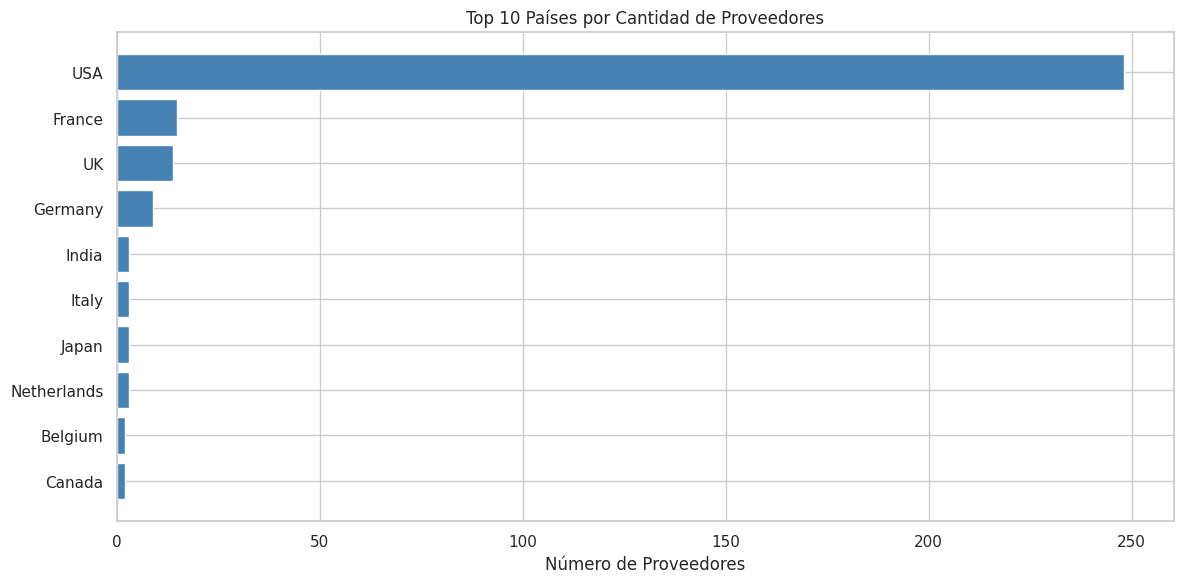



📊 PREGUNTA 2: Categorías más comunes y distribución geográfica
--------------------------------------------------------------------------------

Categorías ordenadas por frecuencia:


,Num_Proveedores,Porcentaje
Category,,
Components,58,18.89
Fasteners,51,16.61
Seals,23,7.49
Bearings,18,5.86
Lighting,15,4.89
Hardware,12,3.91
Connectors,11,3.58
Chemicals,9,2.93
Distribution,9,2.93




Distribución geográfica por categoría (Top 5 categorías):

📍 Components:


,Proveedores,Porcentaje
Country,,
USA,50,86.21
France,3,5.17
UK,2,3.45
Belgium,1,1.72
Spain,1,1.72



📍 Fasteners:


,Proveedores,Porcentaje
Country,,
USA,47,92.16
France,1,1.96
Germany,1,1.96
India,1,1.96
Italy,1,1.96



📍 Seals:


,Proveedores,Porcentaje
Country,,
USA,19,82.61
France,3,13.04
UK,1,4.35



📍 Bearings:


,Proveedores,Porcentaje
Country,,
USA,13,72.22
Germany,2,11.11
Canada,1,5.56
Japan,1,5.56
UK,1,5.56



📍 Lighting:


,Proveedores,Porcentaje
Country,,
USA,9,60.00
Germany,3,20.00
India,1,6.67
Japan,1,6.67
Netherlands,1,6.67




Tabla cruzada: Top 5 Países x Top 5 Categorías


Category,Bearings,Components,Fasteners,Lighting,Seals
Country,,,,,
France,0,3,1,0,3
Germany,2,0,1,3,0
India,0,1,1,1,0
UK,1,2,0,0,1
USA,13,50,47,9,19


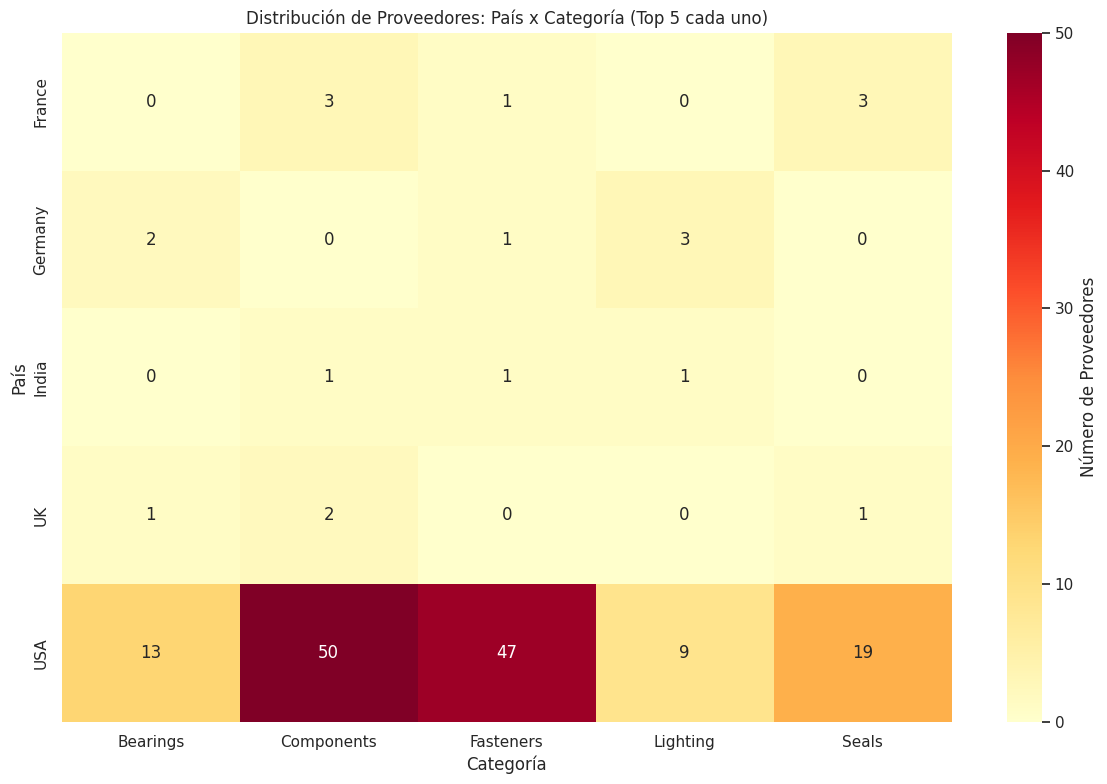



📊 PREGUNTA 3: Análisis de riesgo de concentración geográfica por categoría
--------------------------------------------------------------------------------

Análisis de concentración geográfica por categoría:
(HHI cercano a 1 = alta concentración, cercano a 0 = alta diversificación)


,Category,Total_Proveedores,Paises_Unicos,Pais_Dominante,Porcentaje_Pais_Dominante,Indice_Concentracion_HHI
4,Electrical,9,1,USA,100.00,1.000
23,Ceramics,1,1,USA,100.00,1.000
18,Distribution,9,1,USA,100.00,1.000
19,Fittings,8,1,USA,100.00,1.000
20,Lubrication,1,1,USA,100.00,1.000
17,Batteries,2,1,USA,100.00,1.000
15,Filters,3,1,USA,100.00,1.000
16,Sealants,1,1,USA,100.00,1.000
13,Avionics/Interiors,1,1,USA,100.00,1.000
10,Cables,3,1,USA,100.00,1.000



⚠️ CATEGORÍAS CON ALTO RIESGO DE CONCENTRACIÓN GEOGRÁFICA:
--------------------------------------------------------------------------------

🔴 Electrical:
   - 100.0% de proveedores están en USA
   - Índice de concentración (HHI): 1.0
   - Solo 1 país(es) diferentes

🔴 Ceramics:
   - 100.0% de proveedores están en USA
   - Índice de concentración (HHI): 1.0
   - Solo 1 país(es) diferentes

🔴 Distribution:
   - 100.0% de proveedores están en USA
   - Índice de concentración (HHI): 1.0
   - Solo 1 país(es) diferentes

🔴 Fittings:
   - 100.0% de proveedores están en USA
   - Índice de concentración (HHI): 1.0
   - Solo 1 país(es) diferentes

🔴 Lubrication:
   - 100.0% de proveedores están en USA
   - Índice de concentración (HHI): 1.0
   - Solo 1 país(es) diferentes

🔴 Batteries:
   - 100.0% de proveedores están en USA
   - Índice de concentración (HHI): 1.0
   - Solo 1 país(es) diferentes

🔴 Filters:
   - 100.0% de proveedores están en USA
   - Índice de concentración (HHI): 1.0
   - So

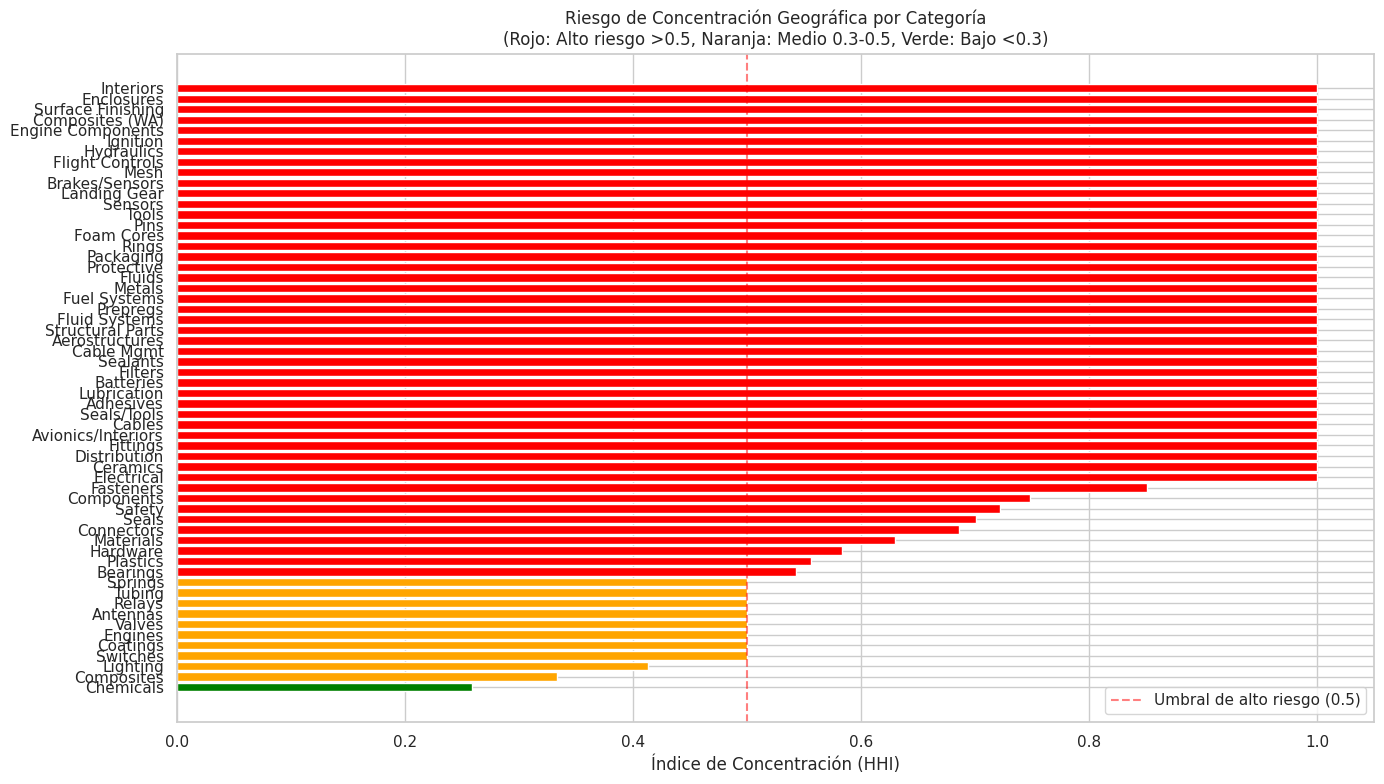


✅ Análisis completado


In [ ]:
# @title Consultas de negocio y agregaciones

print("=" * 80)
print("CONSULTAS DE NEGOCIO - PROVEEDORES DE BOEING")
print("=" * 80)

# ============================================================================
# PREGUNTA 1: ¿Qué países concentran la mayor cantidad de proveedores?
# ============================================================================
print("\n📊 PREGUNTA 1: Distribución geográfica de proveedores")
print("-" * 80)

proveedores_por_pais = df_clean.groupby("Country").agg({
    "Supplier": "count"
}).rename(columns={"Supplier": "Num_Proveedores"}).sort_values("Num_Proveedores", ascending=False)

proveedores_por_pais["Porcentaje"] = (proveedores_por_pais["Num_Proveedores"] / len(df_clean) * 100).round(2)
proveedores_por_pais["Porcentaje_Acumulado"] = proveedores_por_pais["Porcentaje"].cumsum()

print("\nTop 10 países con más proveedores:")
display(proveedores_por_pais.head(10))

print(f"\n📈 Total de países únicos: {df_clean['Country'].nunique()}")
print(f"📈 País con más proveedores: {proveedores_por_pais.index[0]} ({proveedores_por_pais.iloc[0]['Num_Proveedores']} proveedores, {proveedores_por_pais.iloc[0]['Porcentaje']}%)")

# Visualización
plt.figure(figsize=(12, 6))
top_10_paises = proveedores_por_pais.head(10)
plt.barh(range(len(top_10_paises)), top_10_paises["Num_Proveedores"], color='steelblue')
plt.yticks(range(len(top_10_paises)), top_10_paises.index)
plt.xlabel("Número de Proveedores")
plt.title("Top 10 Países por Cantidad de Proveedores")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ============================================================================
# PREGUNTA 2: ¿Cuáles son las categorías más comunes y su distribución geográfica?
# ============================================================================
print("\n\n📊 PREGUNTA 2: Categorías más comunes y distribución geográfica")
print("-" * 80)

# Análisis de categorías
categorias_por_frecuencia = df_clean.groupby("Category").agg({
    "Supplier": "count"
}).rename(columns={"Supplier": "Num_Proveedores"}).sort_values("Num_Proveedores", ascending=False)

categorias_por_frecuencia["Porcentaje"] = (categorias_por_frecuencia["Num_Proveedores"] / len(df_clean) * 100).round(2)

print("\nCategorías ordenadas por frecuencia:")
display(categorias_por_frecuencia)

# Distribución geográfica por categoría
print("\n\nDistribución geográfica por categoría (Top 5 categorías):")
top_5_categorias = categorias_por_frecuencia.head(5).index

for categoria in top_5_categorias:
    print(f"\n📍 {categoria}:")
    distribucion = df_clean[df_clean["Category"] == categoria].groupby("Country").size().sort_values(ascending=False)
    distribucion_pct = (distribucion / distribucion.sum() * 100).round(2)
    resultado = pd.DataFrame({
        "Proveedores": distribucion,
        "Porcentaje": distribucion_pct
    }).head(5)
    display(resultado)

# Tabla cruzada: País x Categoría (solo top países y categorías)
print("\n\nTabla cruzada: Top 5 Países x Top 5 Categorías")
tabla_cruzada = pd.crosstab(
    df_clean[df_clean["Country"].isin(proveedores_por_pais.head(5).index)]["Country"],
    df_clean[df_clean["Category"].isin(top_5_categorias)]["Category"]
)
display(tabla_cruzada)

# Visualización: Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(tabla_cruzada, annot=True, fmt='d', cmap='YlOrRd', cbar_kws={'label': 'Número de Proveedores'})
plt.title("Distribución de Proveedores: País x Categoría (Top 5 cada uno)")
plt.xlabel("Categoría")
plt.ylabel("País")
plt.tight_layout()
plt.show()

# ============================================================================
# PREGUNTA 3: ¿Existe dependencia geográfica excesiva en alguna categoría?
# ============================================================================
print("\n\n📊 PREGUNTA 3: Análisis de riesgo de concentración geográfica por categoría")
print("-" * 80)

# Calcular índice de concentración (HHI - Herfindahl-Hirschman Index) por categoría
# HHI = suma de (porcentaje de cada país)^2
# Valores cercanos a 1 indican alta concentración, valores cercanos a 0 indican diversificación

concentracion_por_categoria = []

for categoria in df_clean["Category"].unique():
    datos_categoria = df_clean[df_clean["Category"] == categoria]
    distribucion_pais = datos_categoria["Country"].value_counts(normalize=True)
    hhi = (distribucion_pais ** 2).sum()  # Índice de concentración
    pais_dominante = distribucion_pais.index[0]
    porcentaje_dominante = distribucion_pais.iloc[0] * 100

    concentracion_por_categoria.append({
        "Category": categoria,
        "Total_Proveedores": len(datos_categoria),
        "Paises_Unicos": datos_categoria["Country"].nunique(),
        "Pais_Dominante": pais_dominante,
        "Porcentaje_Pais_Dominante": round(porcentaje_dominante, 2),
        "Indice_Concentracion_HHI": round(hhi, 3)
    })

df_concentracion = pd.DataFrame(concentracion_por_categoria).sort_values("Indice_Concentracion_HHI", ascending=False)

print("\nAnálisis de concentración geográfica por categoría:")
print("(HHI cercano a 1 = alta concentración, cercano a 0 = alta diversificación)")
display(df_concentracion)

# Identificar categorías con alto riesgo (HHI > 0.5 o país dominante > 70%)
categorias_riesgo = df_concentracion[
    (df_concentracion["Indice_Concentracion_HHI"] > 0.5) |
    (df_concentracion["Porcentaje_Pais_Dominante"] > 70)
]

if len(categorias_riesgo) > 0:
    print("\n⚠️ CATEGORÍAS CON ALTO RIESGO DE CONCENTRACIÓN GEOGRÁFICA:")
    print("-" * 80)
    for _, row in categorias_riesgo.iterrows():
        print(f"\n🔴 {row['Category']}:")
        print(f"   - {row['Porcentaje_Pais_Dominante']}% de proveedores están en {row['Pais_Dominante']}")
        print(f"   - Índice de concentración (HHI): {row['Indice_Concentracion_HHI']}")
        print(f"   - Solo {row['Paises_Unicos']} país(es) diferentes")
else:
    print("\n✅ No se detectaron categorías con concentración geográfica excesiva.")

# Visualización: Concentración por categoría
plt.figure(figsize=(14, 8))
categorias_ordenadas = df_concentracion.sort_values("Indice_Concentracion_HHI", ascending=True)["Category"]
hhi_values = df_concentracion.sort_values("Indice_Concentracion_HHI", ascending=True)["Indice_Concentracion_HHI"]

plt.barh(range(len(categorias_ordenadas)), hhi_values, color=['red' if h > 0.5 else 'orange' if h > 0.3 else 'green' for h in hhi_values])
plt.yticks(range(len(categorias_ordenadas)), categorias_ordenadas)
plt.xlabel("Índice de Concentración (HHI)")
plt.title("Riesgo de Concentración Geográfica por Categoría\n(Rojo: Alto riesgo >0.5, Naranja: Medio 0.3-0.5, Verde: Bajo <0.3)")
plt.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Umbral de alto riesgo (0.5)')
plt.legend()
plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("✅ Análisis completado")
print("=" * 80)

## 5. Conclusiones del mini-pipeline
1. **Resumen del proceso**
- Describe brevemente las etapas: ingesta batch, envío a Kafka, consumo desde Kafka,
limpieza, modelado, calidad del dato y consultas.

    - **Ingesta Batch:** El proceso de ingesta comienza con el uso de la librería kagglehub para descargar el dataset 'Boeing Supplier List' directamente desde Kaggle.

    - **Ingesta en Streaming:** Para simular una ingesta de datos en streaming con Kafka hemos usado un 'productor Kafka' configurado en Python, enviando los registros uno a uno a un cluster que hemos configurado en un servidor propio.

    - **Consumo y Reconstrucción:** Una vez los datos han sido ingeridos por Kafka, hemos configurado un 'Consumidor' en Python que reconstruye la cadena de bytes enviados por Kafka en un dataset legible.

    - **Calidad y Procesamiento:** Una vez hemos reconstruido el dataset procedemos a aplicar técnicas de de limpieza para la eliminación de posibles duplicados generados por reintentos de envío y para la eliminación de valores nulos. Por otro lado se ha aplicado pre-procesamiento 'One-Hot encoding' para las categorías para posterior uso por sistemas de Machine Learning.

    - **Explotación:** Finalmente generamos visualizaciones analíticas para responder a las preguntas de negocio planteadas.

2. **Respuestas a las preguntas de negocio**
- ¿Qué has podido responder?
  - Gracias al análisis de los datos procesados hemos podido llegar a las siguientes conclusiones:

    - **Sobre la distribución geográfica:** Existe una dependencia crítica de Estados Unidos, que concentra la inmensa mayoría de los proveedores, lo que supone un riesgo estratégico.

    - **Sobre las categorías:** Hemos podido visualizar que los productos más consumidos son componentes de hardware como 'Componentes', 'Sujeciones de seguridad' y 'Rodamientos', más que en grandes sistemas como Motores o Fuselajes.

    - **Sobre el riesgo de concentración:** Al cruzar País vs Categoría, observamos que ciertas categorías críticas dependen casi exclusivamente de proveedores estadounidenses, lo que confirma una baja diversificación geográfica en componentes esenciales.

- ¿Qué patrones o insights relevantes has obtenido?

  - La cadena de provisión es tan dependiente de Estados Unidos que una catástrofe natural, huelga masiva o cambio regulatorio en Estados Unidos afectaría simultáneamente a casi todas las categorías de componentes.

  - El predominio de categorías como Fasteners y Bearings sugiere que Boeing gestiona una red de proveedores muy granular para piezas pequeñas y mecánicas. Esto implica una carga logística inmensa (miles de envíos pequeños) que justifica el uso de sistemas Big Data.

3. **Limitaciones y mejoras**

- ¿Qué harías mejor si tuvieras más tiempo o más herramientas (Spark, MongoDB, etc.)?

  - De Procesamiento en Memoria (Pandas) a Procesamiento Distribuido (Apache Spark):

    - Limitación actual: Utilizamos pandas, que carga todo el dataset en la memoria RAM de una sola máquina. Si la lista de proveedores creciera a millones de registros, el sistema fallaría (MemoryError).

    - Mejora: Implementaríamos Spark Structured Streaming. Esto permitiría procesar los micro-lotes de datos en paralelo a través de un cluster de nodos, garantizando escalabilidad horizontal y tolerancia a fallos.

- ¿Qué otras fuentes de datos podrían enriquecer el análisis?

  - Datos Financieros en Tiempo Real.
  - Índices de Riesgo Geopolítico.
  - Datos Logísticos y Meteorológicos.

4. **Relación con el RA3 de Sistemas de Big Data**

- Explica en 4–5 líneas cómo este mini-pipeline te ha permitido

  - Gestionar datos:

    - Hemos implementado una solución que no solo almacena el dato estático, sino que gestiona su movimiento desde el origen (Kaggle) hasta el destino (Análisis). El uso de Apache Kafka demuestra la capacidad de gestionar flujos de datos en tiempo real, separando la ingestión del procesamiento, lo cual es vital en sistemas de Big Data para evitar cuellos de botella.

  - Almacenarlos de forma apropiada:

    - En lugar de depender únicamente del almacenamiento local, hemos configurado un cluster remoto. Esto valida nuestra competencia para seleccionar y utilizar infraestructuras de almacenamiento escalables que garantizan la disponibilidad y la tolerancia a fallos, superando las limitaciones de un sistema de ficheros tradicional.

  - Facilitar la búsqueda de respuestas en grandes conjuntos de datos:

    - El objetivo final del pipeline no era solo mover datos, sino extraer valor. Al limpiar, estructurar y enriquecer los datos brutos y convertirlos a un formato analizable, hemos transformado un conjunto de datos grande y ruidoso en respuestas de negocio concretas.